In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')


pixel_size_image = 299
IMAGE_SIZE = (pixel_size_image, pixel_size_image)  # All images contained in this dataset are pixel_size_imagexpixel_size_image (originally, to match Inception v3 input size)
SEED = 17

data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')


# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

import random
import tensorflow as tf
from PIL import Image 

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

# Correct the function name from '_inner_function' to 'inner_function'
def load_and_preprocess(img_loc, label):
    def inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [pixel_size_image, pixel_size_image])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        # label = tf.one_hot(label, depth=2)
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([pixel_size_image, pixel_size_image, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

def augment_image(image, label):
    # Apply augmentation techniques
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly rotate the image by 0, 90, 180, or 270 degrees
    # rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    # image = tf.image.rot90(image, k=rotations)

    return image, label

# Ensure that the dataset is being augmented
tf_dataset_train_augmented = tf_dataset_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

17:59:02 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


In [3]:
# Make sure to match the input shape to ResNet50's expected input
# ResNet50 generally expects a minimum size of 197x197
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(pixel_size_image, pixel_size_image, 3))

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),  # You can specify the learning rate if needed
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


17:59:03 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:1398: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

17:59:04 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:979: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored metric
)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(
    'RESNET_best_model.h5',  # Path where to save the model
    save_best_only=True,  # Only save a model if `val_loss` has improved
    monitor='val_loss',
    mode='min'
)

# Compile your model with these callbacks
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Fit the model with the dataset
history = model.fit(
    tf_dataset_train_augmented,
    epochs=15,
    validation_data= tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/15


17:59:05 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

17:59:06 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



928/928 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7221 - precision_1: 0.7331 - recall_1: 0.8289

C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 615s 660ms/step - loss: 0.5515 - accuracy: 0.7221 - precision_1: 0.7331 - recall_1: 0.8289 - val_loss: 12.3557 - val_accuracy: 0.3218 - val_precision_1: 0.3218 - val_recall_1: 1.0000
Epoch 2/15
928/928 [==============================] - 610s 658ms/step - loss: 0.5107 - accuracy: 0.7536 - precision_1: 0.7647 - recall_1: 0.8390 - val_loss: 0.6275 - val_accuracy: 0.7768 - val_precision_1: 0.9955 - val_recall_1: 0.3078
Epoch 3/15
928/928 [==============================] - 614s 662ms/step - loss: 0.4969 - accuracy: 0.7637 - precision_1: 0.7740 - recall_1: 0.8446 - val_loss: 0.3374 - val_accuracy: 0.8487 - val_precision_1: 0.9361 - val_recall_1: 0.5686
Epoch 4/15
928/928 [==============================] - 621s 670ms/step - loss: 0.4953 - accuracy: 0.7654 - precision_1: 0.7751 - recall_1: 0.8465 - val_loss: 0.3240 - val_accuracy: 0.8500 - val_precision_1: 0.8616 - val_recall_1: 0.6360
Epoch 5/15
928/928 [==============================] - 620s 668ms/s

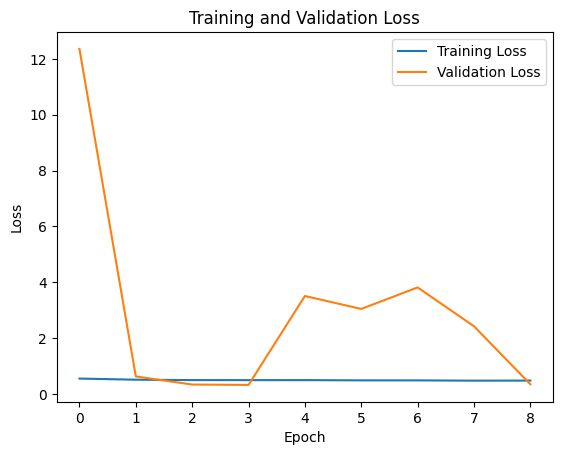

401/401 [==============================] - 189s 471ms/step - loss: 0.6544 - accuracy: 0.6680 - precision_1: 0.9650 - recall_1: 0.5121
Test Loss: 0.6543805599212646
Test Accuracy: 0.6680184006690979
Test Precision: 0.9650224447250366
Test Recall: 0.5120761394500732
F1 Score: 0.669102216022279


In [5]:
import matplotlib.pyplot as plt

# Ensure you have the history object from your model training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


test_loss, test_accuracy, test_precision, test_recall = model.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) != 0 else 0
print(f"F1 Score: {f1_score}")
